# Segment Anything Model as Inference

In [2]:
# Standard library imports
import os
import shutil
import csv
import warnings
from pathlib import Path

# Third-party library imports
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import sobel, rank
from skimage.segmentation import watershed, felzenszwalb
from scipy import ndimage as ndi
from skimage.morphology import disk
from pycocotools import mask as maskUtils

# Local imports
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import sklearn.metrics
from sklearn.metrics import adjusted_rand_score


## Importing and preparing work directory and data

In [4]:
# Define the path to the data directory and load the train labels and trains
DATA_PATH = "./../../data/"
data_dir = Path(DATA_PATH)
labels_train = pd.read_csv(data_dir / "Y_train.csv", index_col=0).T


def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)


data_train = load_dataset(data_dir / "X_train")


In [5]:
# We create a file containing only labeled X_train images to compute metrics using SAM for inference.
path_to_X_train = f'{DATA_PATH}X_train/'
path_to_X_train_ground_truth = f'{DATA_PATH}X_train_ground_truth'
os.makedirs(path_to_X_train_ground_truth, exist_ok=True)

# Copy the labeled images to the new folder
for i in range(200):
    image_path = os.path.join(path_to_X_train, str(i) + '.png')
    ground_truth_path = os.path.join(
        path_to_X_train_ground_truth, str(i) + '.png')
    shutil.copyfile(image_path, ground_truth_path)

# Create the predictions directory folder if it does not exist
predictions_dir = f'{DATA_PATH}predictions/inference_sam/'
os.makedirs(predictions_dir, exist_ok=True)

# Set the directory for inferenced images
inference_dir = f'{DATA_PATH}X_train_ground_truth/'


## Computing the inference

In [4]:
# Load the pre-trained Vision Transformer model using the SAM library
sam = sam_model_registry["vit_l"](
    checkpoint="./checkpoints_sam/sam_vit_l_0b3195.pth")


In [5]:
import pickle
from tqdm import tqdm

# Get the list of files in the directory and sort them
files = os.listdir(inference_dir)

# Loop over each image in the directory with a progress bar
for filename in tqdm(files):
    # Read the image and convert it to RGB
    image = cv2.imread(os.path.join(inference_dir, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate the mask using the SamAutomaticMaskGenerator object
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image)

    # Remove the file extension for naming the files when saving outputs
    filename_without_extension = os.path.splitext(filename)[0]

    # Save the masks to a file
    with open(f'{predictions_dir}{filename_without_extension}.pkl', 'wb') as f:
        pickle.dump(masks, f)


100%|██████████| 201/201 [4:58:43<00:00, 89.17s/it]     


## Vizualization and Comparison between ground truth and SAM output

In [21]:
# Choose the scan you want to plot
chosen_scan = 175

# Set the paths to the image and mask files
chosen_image = f"{DATA_PATH}/X_train_ground_truth/{chosen_scan}.png"
chosen_mask_file = f"{DATA_PATH}/predictions/inference_sam/{chosen_scan}.pkl"

# Load the mask from the pickle file
with open(chosen_mask_file, "rb") as f:
    chosen_mask = pickle.load(f)

# Load the image and convert it from BGR to RGB format
image = cv2.imread(chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [22]:
def show_sam(sam_output):
    """
    Show SAM segmentations.

    Args:
        sam_output (list): Output of SAM.

    Returns:
        None
    """

    if len(sam_output) == 0:
        return
    sorted_anns = sorted(sam_output, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


def plot_slice_seg(slice_image, seg, image, mask):
    """
    Plot the original CT-scan, ground truth segmentation, and SAM output.

    Args:
        slice_image (np.ndarray): The original CT-scan slice.
        ground_truth (np.ndarray): The ground truth segmentation mask.
        image (np.ndarray): The SAM output image.
        mask (list): Output of SAM.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    axes[2].imshow(image)
    show_sam(mask)
    seg_masked = np.ma.masked_where(seg.reshape(
        (512, 512)) == 0, (seg.reshape((512, 512))))
    axes[1].imshow(seg_masked, cmap="tab20")

    # Set titles for each axis
    axes[0].set_title("Original CT-Scan")
    axes[1].set_title("Ground Truth Segmentation")
    axes[2].set_title("SAM output")

    # Turn off the axis labels
    for ax in axes:
        ax.axis("off")


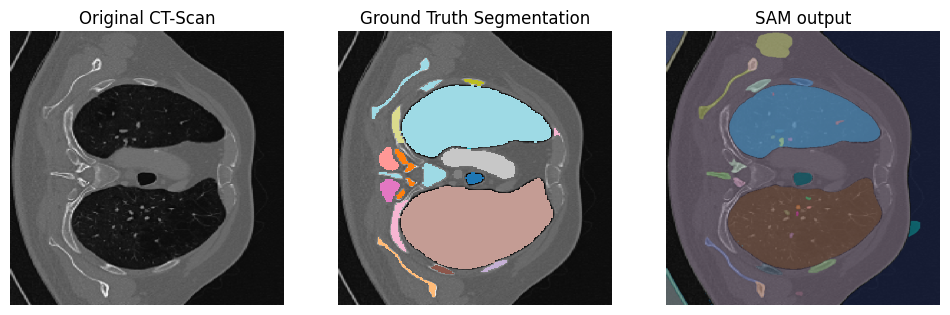

In [23]:
plot_slice_seg(data_train[chosen_scan], labels_train.iloc[chosen_scan].values.reshape(
    (512, 512)), image, chosen_mask)


## Computing some metrics

In [29]:
iou_scores = []
dsc_scores = []
precision_scores = []
recall_scores = []
individual_rand_index = []

# loop through all sam output files in the predictions directory
for filename in os.listdir(f"{DATA_PATH}predictions/inference_sam"):
    if filename.endswith(".pkl"):
        
        # read sam output from file
        sam_output = pd.read_pickle(os.path.join(f"{DATA_PATH}predictions/inference_sam", filename))
        # get corresponding ground truth mask
        img_id = os.path.splitext(filename)[0] + ".png"
        ground_truth = np.array(labels_train.T[img_id]).reshape((512, 512))
        
        # loop through all segmented objects in sam output
        for sam_obj in sam_output:
            
            # convert SAM segmentation mask to RLE format
            sam_mask_rle = maskUtils.encode(np.asfortranarray(sam_obj['segmentation'].astype(np.uint8)))
            # convert ground truth mask to RLE format
            ground_truth_rle = maskUtils.encode(np.asfortranarray(ground_truth.astype(np.uint8)))
            
            # compute metrics
            sam_mask = maskUtils.decode(sam_mask_rle)
            ground_truth = maskUtils.decode(ground_truth_rle)
            intersection = np.logical_and(sam_mask, ground_truth).sum()
            union = np.logical_or(sam_mask, ground_truth).sum()
            
            # convert SAM segmentation mask to flat array
            sam_mask_flat = sam_mask.ravel()
            # convert ground truth mask to flat array
            ground_truth_flat = ground_truth.ravel()

            # compute individual Rand index
            individual_rand = adjusted_rand_score(sam_mask_flat, ground_truth_flat)
            individual_rand_index.append(individual_rand)

            iou_score = intersection / union
            iou_scores.append(iou_score)
            
            dsc_score = (2.0 * intersection) / (sam_mask.sum() + ground_truth.sum())
            dsc_scores.append(dsc_score)
            
            if sam_mask.sum() == 0:
                precision_score = np.nan
            else:
                precision_score = intersection / sam_mask.sum()
            precision_scores.append(precision_score)
            if ground_truth.sum() == 0:
                recall_score = np.nan
            else:
                recall_score = intersection / ground_truth.sum()
            recall_scores.append(recall_score)

# compute average scores across all segmented objects
avg_iou = np.nanmean(iou_scores)
avg_dsc = np.nanmean(dsc_scores)
avg_precision = np.nanmean(precision_scores)
avg_recall = np.nanmean(recall_scores)
avg_rand_index = np.nanmean(individual_rand_index)

print("Average IOU: {:.4f}".format(avg_iou))
print("Average DSC: {:.4f}".format(avg_dsc))
print("Average Precision: {:.4f}".format(avg_precision))
print("Average Recall: {:.4f}".format(avg_recall))
print("Average Rand Index: {:.4f}".format(avg_rand_index))


Average IOU: 0.0276
Average DSC: 0.0430
Average Precision: 0.4272
Average Recall: 0.0439
Average Rand Index: 0.0067
